## Import libraries

In [41]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


## Read CSV

In [42]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
print(data.columns.tolist())
data.set_index('Date', inplace=True)
display(data)


['Date', 'AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L', 'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO', 'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L']


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [43]:
first_prices = data.iloc[:1]
first_prices.values

array([[ 21.90244293,   6.24662399,  40.        ,  42.61999893,
         26.04221153,  22.38007736,  42.7570076 ,  12.30733013,
         20.62557411,  14.72088146,  10.45192623,  30.00427818,
         14.19258881,  13.14745522,  19.75927925,  41.37704086,
        155.91999817,  13.62710571,  35.37962341,  23.19848824,
         20.75997353,   8.67868042,   5.19500017,  28.82999992,
        100.45068359,  83.88857269, 317.51998901,  69.90565491,
         42.30095673,  27.66472244,  34.59193802,  33.70780945,
          6.78375006]])

In [44]:
normalized_data = data.copy()
normalized_data = data / first_prices.values
normalized_data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.000000,1.000000,1.000000,0.997419,1.004719,1.000000,1.000000,1.011775,0.998175,0.990533,...,0.984738,1.001569,0.988110,1.002016,1.002994,1.000000,0.987854,0.982903,1.005346,0.987286
2012-01-05,1.000000,1.000000,1.000000,0.973956,0.991237,1.000000,1.000000,0.998641,0.991971,0.979073,...,0.988900,1.004235,0.986352,0.986898,0.998744,1.000000,0.969867,0.992135,0.993009,0.985075
2012-01-06,1.000000,1.000000,1.000000,0.970202,0.995281,1.000000,1.000000,0.985507,0.981752,0.961136,...,0.968089,1.001647,0.994139,0.988158,0.992660,1.000000,0.956552,0.988887,0.981082,0.991524
2012-01-09,1.000000,1.000000,1.000000,0.989911,0.991911,1.000000,1.000000,0.988677,0.984671,0.965122,...,0.975720,1.004078,0.992381,0.984631,0.996426,1.000000,0.963793,0.985468,0.981904,0.987102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1.747568,1.665700,2.513750,0.444158,0.542965,4.822593,1.321187,1.925682,2.012550,2.583405,...,1.039195,5.715043,1.058428,0.235828,1.845788,3.316001,2.592833,2.622808,2.215807,1.221669
2025-03-25,1.752316,1.671303,2.518000,0.440404,0.538741,4.795783,1.323292,1.934619,2.022247,2.607181,...,1.060701,5.728782,1.058311,0.235639,1.851925,3.320965,2.608376,2.593379,2.227674,1.201216
2025-03-26,1.728300,1.664899,2.454250,0.435476,0.541813,4.729206,1.311598,1.926494,2.006247,2.551478,...,1.058966,5.660390,1.051354,0.237528,1.863226,3.300044,2.571506,2.603497,2.207500,1.200663


In [45]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)


In [46]:
def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        X.append(window.values)
        
        y_target = df.iloc[i+window_size]
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
                
    X = np.array(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels



## Train the model

In [ ]:
window_size = 30
dataset_size = len(normalized_data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = normalized_data.iloc[:train_size]
val_data = normalized_data.iloc[train_size:train_size + val_size]
test_data = normalized_data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


X_train, y_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (312, 30, 33),
 (312, 33),
 (310, 30, 33),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

In [48]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False, activation='linear'),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])


cp = ModelCheckpoint(filepath='model/best_first.keras', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp]
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - loss: 0.7421 - mean_squared_error: 0.7419 - val_loss: 0.1579 - val_mean_squared_error: 0.1582
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1529 - mean_squared_error: 0.1529 - val_loss: 0.1251 - val_mean_squared_error: 0.1255
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.1052 - mean_squared_error: 0.1052 - val_loss: 0.0918 - val_mean_squared_error: 0.0923
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0805 - mean_squared_error: 0.0805 - val_loss: 0.0891 - val_mean_squared_error: 0.0896
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0687 - mean_squared_error: 0.0686 - val_loss: 0.1033 - val_mean_squared_error: 0.1038
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0614 - mean_squared_error: 0.0614 - val_loss: 0.0734 - val_mean_squared_error: 0.0739
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - val_loss: 0.0586 

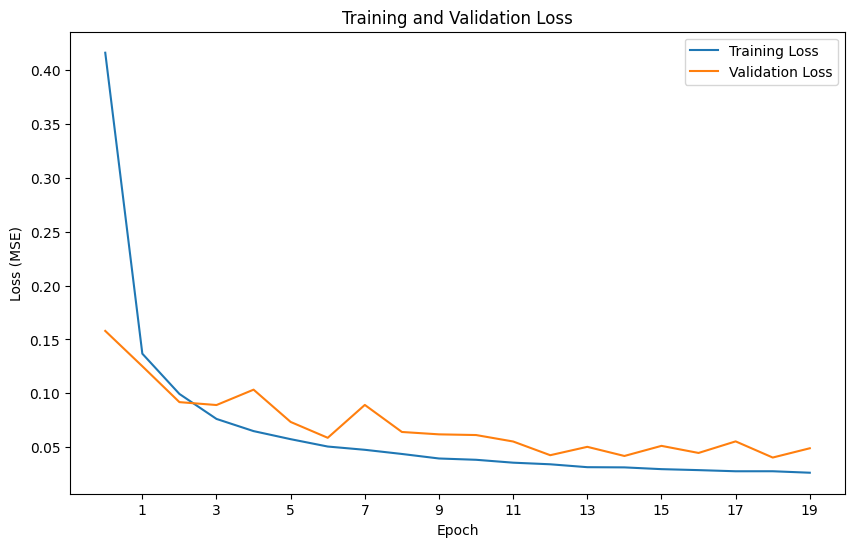

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 21, 2)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

## Predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,38.780830,12.451551,98.669453,24.369749,17.245372,103.808414,55.137944,23.096891,37.998211,28.603358,...,20.844205,454.737701,116.482101,91.594168,99.192218,111.234759,59.713689,101.322356,69.078594,7.499869
2024-01-18,38.748337,12.447184,98.446093,24.286329,17.209127,103.779579,55.059985,23.084940,37.982613,28.589265,...,20.809808,454.583659,116.386878,91.037413,99.135118,111.225511,59.678573,101.271074,69.045427,7.488615
2024-01-19,38.700840,12.442530,98.237591,24.221474,17.178828,103.742634,54.984228,23.065874,37.961684,28.570507,...,20.776685,454.382916,116.298896,90.594022,99.079425,111.191947,59.641274,101.203446,69.011537,7.475698
2024-01-22,38.657744,12.439873,98.008595,24.174216,17.165283,103.696799,54.920433,23.047616,37.944514,28.553306,...,20.749057,454.188495,116.288705,90.346815,99.070900,111.159805,59.618967,101.155677,68.995319,7.466451
2024-01-23,38.626404,12.436923,97.826538,24.138725,17.160614,103.649684,54.888312,23.032178,37.933649,28.541347,...,20.718418,454.156834,116.289505,90.173390,99.085092,111.159149,59.595802,101.136873,68.973901,7.458340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,41.675156,13.213522,109.952459,25.441934,17.786693,106.791803,57.408040,24.281905,39.437488,30.843304,...,22.364496,476.356216,127.849049,105.960859,101.556605,116.152187,63.618822,105.177915,73.378367,7.946304
2025-03-25,41.602469,13.203122,109.812136,25.462603,17.819023,106.655771,57.366933,24.252511,39.421405,30.861818,...,22.340467,475.543807,127.623052,106.629777,101.590755,115.962280,63.592979,105.011698,73.375779,7.957420
2025-03-26,41.558925,13.195942,109.701395,25.496588,17.860946,106.566972,57.349776,24.231856,39.422588,30.881718,...,22.336876,474.947517,127.468748,107.368503,101.675839,115.819582,63.583864,104.896581,73.391193,7.968108


<Axes: xlabel='Date'>

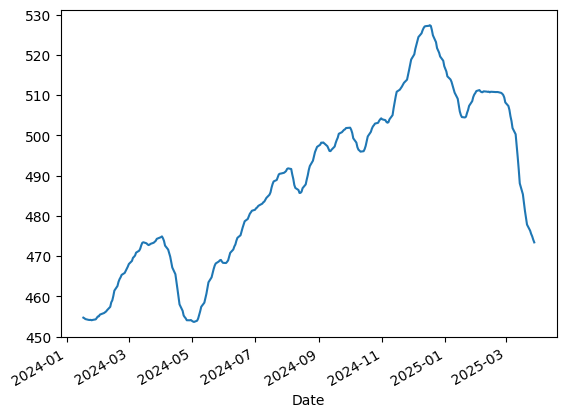

In [50]:
model = load_model('model/best_first.keras')
Y_pred = model.predict(X_test)

index_series = data.index[-len(y_test):]
Y_pred_denormalized = Y_pred * first_prices.values

Y_pred_df = pd.DataFrame(Y_pred_denormalized, index = index_series, columns = data.columns)

display(Y_pred_df)

Y_pred_df["SPY"].plot()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.1039
Mean Absolute Error: 0.2500
R-squared: -14.0263


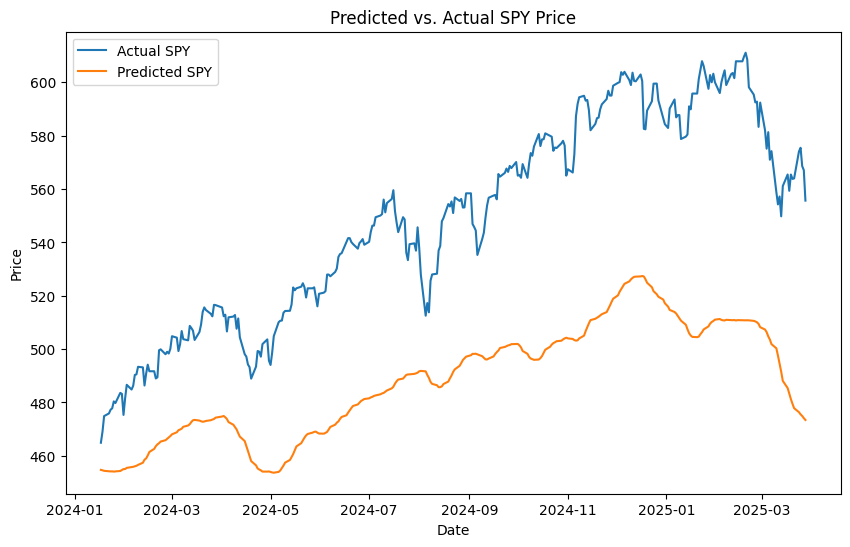

In [52]:
y_actual = pd.DataFrame(y_test * first_prices.values, index=index_series, columns=data.columns)

plt.figure(figsize=(10,6))
plt.plot(y_actual["SPY"], label='Actual SPY')
plt.plot(Y_pred_df["SPY"], label='Predicted SPY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs. Actual SPY Price')
plt.legend()
plt.show()


In [53]:
print("Mean of actual normalized prices:", np.mean(y_test))
print("Mean of predicted normalized prices:", np.mean(Y_pred))


Mean of actual normalized prices: 2.004547767619129
Mean of predicted normalized prices: 2.0260842


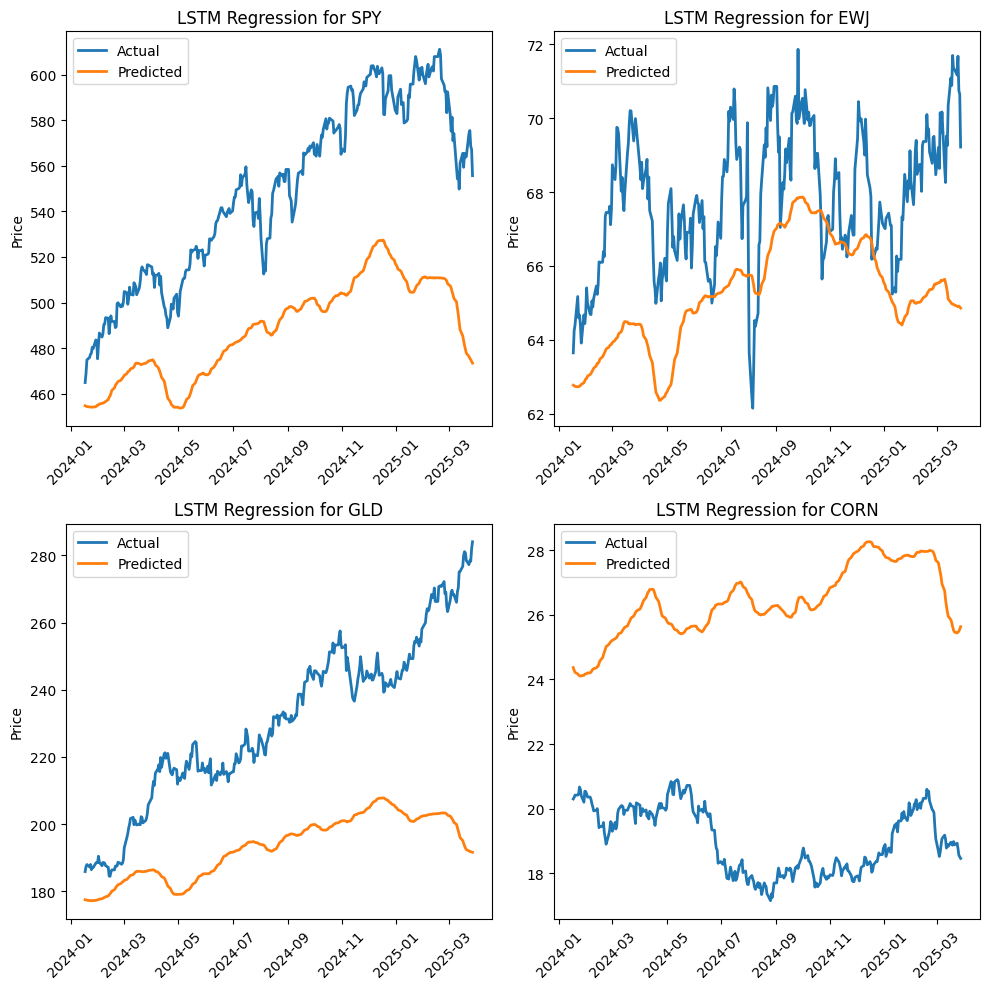

In [54]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Y_pred_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [55]:
label = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
label_test = label.iloc[-len(y_test):]
label_test.set_index('Date', inplace=True)
display(label_test)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2024-01-18,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,0,1,1
2024-01-19,1,1,0,1,0,0,1,1,1,1,...,0,1,1,0,1,1,1,1,1,0
2024-01-22,1,0,1,0,1,0,0,0,0,1,...,0,1,1,1,1,1,1,1,1,1
2024-01-23,1,1,0,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [56]:
Y_pred_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,38.780830,12.451551,98.669453,24.369749,17.245372,103.808414,55.137944,23.096891,37.998211,28.603358,...,20.844205,454.737701,116.482101,91.594168,99.192218,111.234759,59.713689,101.322356,69.078594,7.499869
2024-01-18,38.748337,12.447184,98.446093,24.286329,17.209127,103.779579,55.059985,23.084940,37.982613,28.589265,...,20.809808,454.583659,116.386878,91.037413,99.135118,111.225511,59.678573,101.271074,69.045427,7.488615
2024-01-19,38.700840,12.442530,98.237591,24.221474,17.178828,103.742634,54.984228,23.065874,37.961684,28.570507,...,20.776685,454.382916,116.298896,90.594022,99.079425,111.191947,59.641274,101.203446,69.011537,7.475698
2024-01-22,38.657744,12.439873,98.008595,24.174216,17.165283,103.696799,54.920433,23.047616,37.944514,28.553306,...,20.749057,454.188495,116.288705,90.346815,99.070900,111.159805,59.618967,101.155677,68.995319,7.466451
2024-01-23,38.626404,12.436923,97.826538,24.138725,17.160614,103.649684,54.888312,23.032178,37.933649,28.541347,...,20.718418,454.156834,116.289505,90.173390,99.085092,111.159149,59.595802,101.136873,68.973901,7.458340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,41.675156,13.213522,109.952459,25.441934,17.786693,106.791803,57.408040,24.281905,39.437488,30.843304,...,22.364496,476.356216,127.849049,105.960859,101.556605,116.152187,63.618822,105.177915,73.378367,7.946304
2025-03-25,41.602469,13.203122,109.812136,25.462603,17.819023,106.655771,57.366933,24.252511,39.421405,30.861818,...,22.340467,475.543807,127.623052,106.629777,101.590755,115.962280,63.592979,105.011698,73.375779,7.957420
2025-03-26,41.558925,13.195942,109.701395,25.496588,17.860946,106.566972,57.349776,24.231856,39.422588,30.881718,...,22.336876,474.947517,127.468748,107.368503,101.675839,115.819582,63.583864,104.896581,73.391193,7.968108


In [57]:
y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_df > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,1,1,1,1,1,0,1,1,1,1,...,0,0,1,1,0,0,0,1,1,1
2024-01-18,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,0,0,1,1,1,1
2024-01-19,1,1,1,1,1,0,1,1,1,1,...,0,0,1,1,0,0,0,1,1,1
2024-01-22,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,0,0,0,1,1,1
2024-01-23,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,0,0,...,0,0,1,1,0,0,0,1,0,0
2025-03-25,1,1,1,1,1,0,1,1,0,0,...,0,0,1,1,0,0,0,1,0,0
2025-03-26,1,1,1,1,1,0,1,1,0,0,...,0,0,1,1,0,0,0,1,0,0


In [58]:
actual_flat = label_test.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 49.27%
Accuracy of the model: 0.4927
